<a href="https://colab.research.google.com/github/luishgh/ICD---Projeto-Final/blob/main/Projeto_ICD_Grupo_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICD - Grupo 17: Ranqueamento de Edições da Final Mundial do ICPC

Alunos:

*   Ivanir Paulo Cardoso Ignacchitti
*   Luis Henrique Gomes Higino
*   Mateus Vitor Mota Vasconcelos


# Introdução
Neste trabalho será realizada uma exploração da base de dados de rankings da competição mundial do [ICPC](https://icpc.global/), a maratona mundial de programação. Aqui, buscamos responder às seguintes perguntas:
- Os países sede da competição tem alguma vantagem nos rankings?
- Qual o rendimento histórico dos times brasileiros em relação a times de outros países?
- Com que acurácia é possível prever um resultado futuro de acordo com o resultado histórico?


# Metodologia
Para este trabalho, foi utilizada a base de dados ICPC WF Ranking Results (1999 - Present) disponível no site [Kaggle](https://www.kaggle.com/datasets/justinianus/icpc-world-finals-ranking-since-1999/data). Nela, temos uma lista com as equipes universitárias que participaram da disputa entre os anos de 1999 e 2023. Para este trabalho, foram utilizados os dados até o ano de 2021.

Cada linha da base de dados corresponde a uma equipe que participou da disputa em alguma das edições. Entre os campos de informação, temos tanto informações sobre a equipe (ranking, universidade, país de origem, nomes dos participantes, medalhas e pontuação) quanto sobre a competição em questão (a data, o local, o país sede e a cidade).

Nós optamos por exibir as médias dos rankings em forma gráfica para comparar grupos distintos, como os times brasileiros e os não-brasileiros, ou times do país sede e de países estrangeiros.

Assim, nós observamos um comportamento esperado, e então quantificamos essas diferenças com o uso de intervalos de confiança, criados por meio de bootstrap, para descobrir o quão expressiva é a diferença em cada pergunta realizada.

Por fim, nós utilizamos de florestas aleatórias de decisão para predizer o resultado de países, e medimos sua acurácia com outra porção dos dados.

# Carregamento dos Dados

In [1]:
!gdown 1JUBdJiq8HamFeeoMkiFKP4fdaeQ3S9dc

Downloading...
From: https://drive.google.com/uc?id=1JUBdJiq8HamFeeoMkiFKP4fdaeQ3S9dc
To: /content/icpc-full.csv
100% 462k/462k [00:00<00:00, 62.6MB/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


## Pré-Processamento

Ao fazer uma análise manual dos dados e cruzar as informações com outras fontes, foi notado que times que se classificaram para a final mundial mas não compareceram ou tiveram sua participação desclassificada aparecem com a coluna "Rank" nula. Como essas instâncias não agregam muito na análise dos resultados, essas linhas vão ser descartadas.

In [3]:
df = pd.read_csv('icpc-full.csv')
df = df.dropna(subset=['Rank'])
df.columns

Index(['Year', 'Date', 'Host', 'City', 'Venue', 'Rank', 'University',
       'Country', 'Team', 'Contestant 1', 'Contestant 2', 'Contestant 3',
       'Gold', 'Silver', 'Bronze', 'Honorable', 'Score', 'Total',
       'Score Percentage', 'Penalty', 'Prize'],
      dtype='object')

As principais colunas são o Rank, que indica a posição final do time e o conjunto de colunas que identifica o time e a competição (Year, Host, University e Team). As outras colunas trazem informações menos interessantes do ponto de vista da Analíse Exploratória e Predição/Classificação.

Abaixo seguem os últimos campeões mundiais como exemplos de instâncias da base de dados.

In [4]:
df[df['Rank'] == 1].sort_values(by = 'Year', ascending=False).head(5)

,Year,Date,Host,City,Venue,Rank,University,Country,Team,Contestant 1,...,Contestant 3,Gold,Silver,Bronze,Honorable,Score,Total,Score Percentage,Penalty,Prize
2176,2021,2022-11-10,Bangladesh,Dhaka,International Convention City Bashundhara,1.0,Massachusetts Institute of Technology,United States,MIT ZEROONE,Jerry Mao,...,Xiao Mao,True,False,False,False,11.0,12,0.92,1339.0,"World Champion, North America Champion"
2059,2020,2021-10-05,Russia,Moscow,Moscow Manege,1.0,Nizhny Novgorod State University,Russia,Almost Retired,Aleksei Daniliuk,...,Valeria Ryabchikova,True,False,False,False,12.0,15,0.80,1714.0,"World Champion, Northern Eurasia Champion"
1924,2019,2019-04-04,Portugal,Porto,Alfândega Congress Centre,1.0,Moscow State University,Russia,Moscow SU: Red Panda,Grigory Reznikov,...,Vladislav Makeev,True,False,False,False,10.0,11,0.91,1531.0,"World Champion, Northern Eurasia Champion"
1784,2018,2018-04-19,China,Beijing,Peking University's Khoo Teck Puat Gymnasium,1.0,Moscow State University,Russia,Moscow SU Red Panda,Grigory Reznikov,...,Vladislav Makeev,True,False,False,False,9.0,11,0.82,1427.0,"World Champion, Northern Eurasia Champion"
1651,2017,2017-05-24,United States,"Rapid City, SD",Rushmore Plaza Civic Center,1.0,St. Petersburg ITMO University,Russia,SPb ITMO University 1,Ilya Zban,...,Vladimir Smykalov,True,False,False,False,10.0,12,0.83,1093.0,"World Champion, Europe Champion"


O rank em cada ano tem escalas diferentes devido ao número variado de participantes de cada edição. Vamos normalizar a coluna Rank em cada edição para um valor proporcional a 100 para tornar possível uma comparação direta entre edições diferentes.

In [5]:
# Agrupa o DataFrame por ano e calcula o número total de participantes em cada ano
grouped = df.groupby('Year')['Rank'].max()

# Normaliza a coluna 'Rank' dividindo pelo número total de participantes em cada ano
for year, max_rank in grouped.items():
    df.loc[df['Year'] == year, 'Rank'] = df.loc[df['Year'] == year, 'Rank'] / max_rank * 100

# EDA

## Número de times participantes do país sede em cada edição

<Axes: xlabel='Year,Host'>

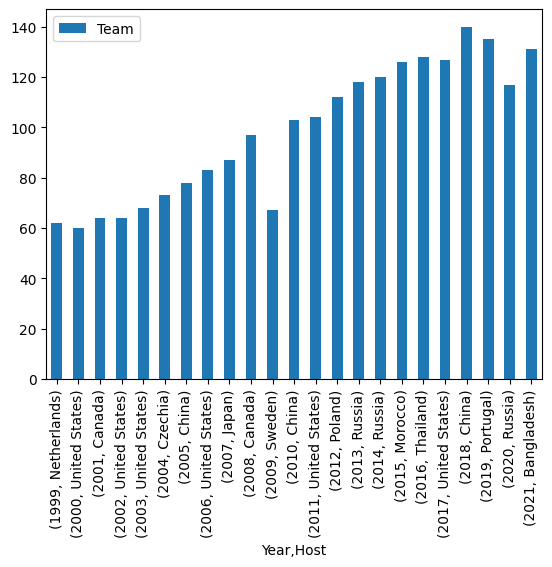

In [6]:
df[['Year', 'Host', 'Team']].groupby(['Year', 'Host']).count().plot.bar()

## Os times do país sede tem vantagem na competição?

A primeira pergunta que queremos responder é: em média, os times do país que está sediando a competição tem um desempenho melhor que os times de países visitantes?

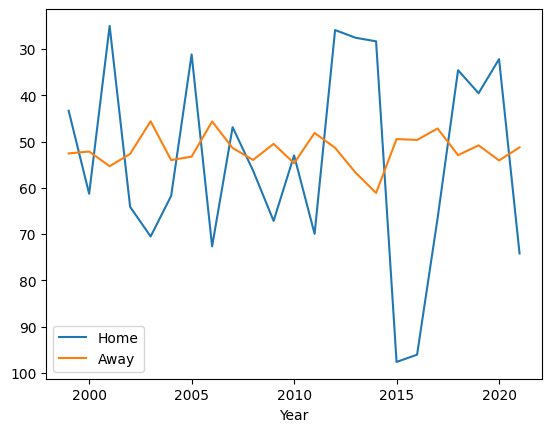

In [7]:
home = df[df['Host']==df['Country']][['Year', 'Rank']].groupby(['Year']).mean().rename(columns = { 'Rank':'Home' })
away = df[df['Host']!=df['Country']][['Year', 'Rank']].groupby(['Year']).mean().rename(columns = { 'Rank':'Away' })
ax = pd.concat([home, away]).plot.line()
ax.invert_yaxis()

A comparação das equipes que estão jogando em casa e fora não demonstra um padrão tão claro, oscilando bastante de um ano para o outro. Por conta disso, suspeitamos que vantagens e desvantagens tivessem mais relação com a performance geral do país.

Logo, vamos investigar melhor essa diferença. Primeiro, qual a diferença do desempenho médio em edições em casa e fora pra cada um dos países que já foi sede? Como não houveram tantos países sedes até hoje na ICPC, conseguimos fazer um gráfico de barras com todos eles:

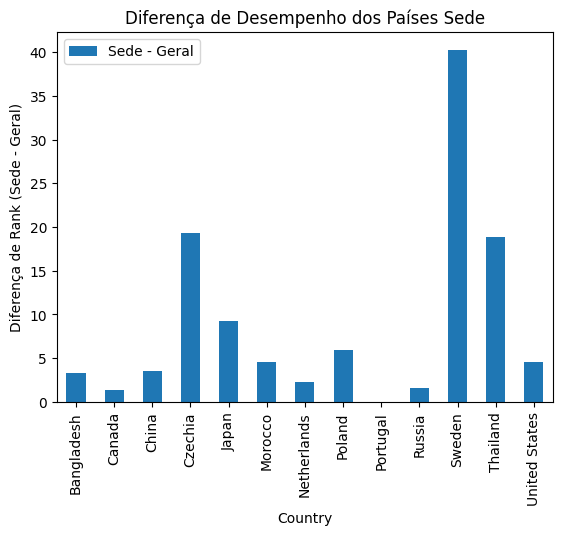

In [8]:
# Calcula a média do rank de cada país em todas as edições
country_mean = df[['Country', 'Rank']].groupby('Country').mean().copy()

# Calcula a média do rank de cada país nas edições que sediou
country_host_mean = df[df['Host'] == df['Country']][['Country', 'Rank']].groupby('Country').mean().copy()

# Une os dois DataFrames e calcula a diferença
diff = country_host_mean.join(country_mean, on='Country', lsuffix='_host', rsuffix='_all')
diff['diff'] = diff['Rank_host'] - diff['Rank_all']

# Plota o gráfico da diferença
diff.plot.bar(y='diff', label='Sede - Geral')
plt.ylabel('Diferença de Rank (Sede - Geral)')
plt.title('Diferença de Desempenho dos Países Sede')
plt.show()


Apesar da diferença favorecer as edições em casa para todos os países, observou-se pouca diferença (abaixo de 10 posições) na maior parte dos casos ao comparar os ranks médios gerais desses países ao longo dos anos com o das edições em que foram hosts. As exceções foram a República Tcheca, a Tailandia e a Suécia.

### Intervalo de Confiança desconsiderando outras variáveis (como ano/edição)

Comentário: acreditamos que o intervalo de confiança ofereça pouco no nosso contexto, pois possuímos os dados de toda a população de interesse, logo não é necessário aproximar a distribuição da população.

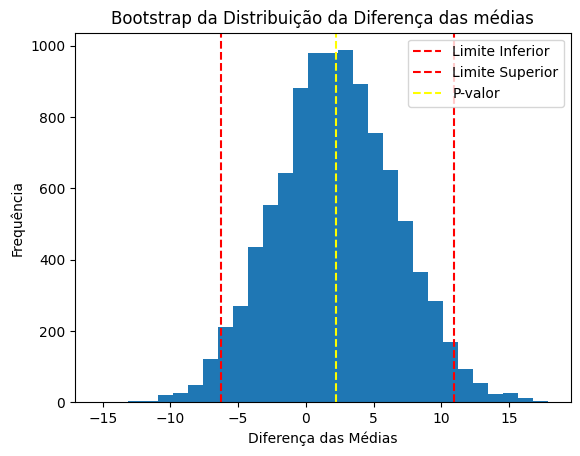

In [9]:
# Calcula valor dos dados
diff_means = home['Home'].values.mean() - away['Away'].values.mean()

# Calcula IC da diferença média via boostrap
n_bootstraps = 10000
bootstrap_diffs = []
for _ in range(n_bootstraps):
  home_sample = np.random.choice(home['Home'].values, size=len(home['Home'].values), replace=True)
  away_sample = np.random.choice(away['Away'].values, size=len(away['Away'].values), replace=True)

  bootstrap_diff = np.mean(home_sample) - np.mean(away_sample)
  bootstrap_diffs.append(bootstrap_diff)

# Calcula intervalo de confiança com 5% de significância
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

plt.hist(bootstrap_diffs, bins=30)
plt.axvline(confidence_interval[0], color='red', linestyle='--', label='Limite Inferior')
plt.axvline(confidence_interval[1], color='red', linestyle='--', label='Limite Superior')
plt.axvline(diff_means, color='yellow', linestyle='--', label='P-valor')
plt.xlabel("Diferença das Médias")
plt.ylabel("Frequência")
plt.title("Bootstrap da Distribuição da Diferença das médias")
plt.legend()
plt.show()


### Conclusão

Através das investigações acima, é possível concluir que os dados indicam que a localidade da competição não é um fator significativo no desempenho dos times.

## Como é o desempenho histórico de universidades brasileiras na competição?

A próxima pergunta é qual o desempenho histórico do Brasil na competição. Uma primeira métrica a ser observada é, naturalmente, o rank médio dos times brasileiros em todas as edições:

In [10]:
df[df['Country'] == 'Brazil']['Rank'].mean()

63.08385431546581

A média dos ranks das equipes brasileiras seria o equivalente ao 63° lugar em 100.

Agora, vamos observar como a média brasileira varia em comparação com a média dos outros países:

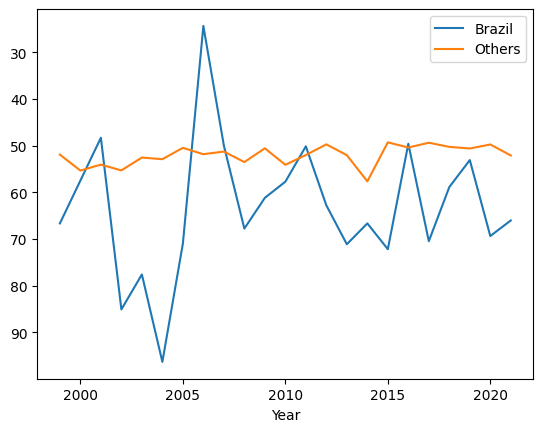

In [11]:
br = df[df['Country']=='Brazil'][['Year', 'Rank']].groupby(['Year']).mean().rename(columns = { 'Rank':'Brazil' })
others = df[df['Country']!='Brazil'][['Year', 'Rank']].groupby(['Year']).mean().rename(columns = { 'Rank':'Others' })
ax = pd.concat([br, others]).plot.line()
ax.invert_yaxis()

É possível notar que o Brasil tende a ficar abaixo da média dos outros países, com uma participação particularmente ruim em 2004 e outra consideravelmente acima do esperado em 2006.

Vamos, pra fim de completude, calcular o intervalo de confiança dessa diferença:

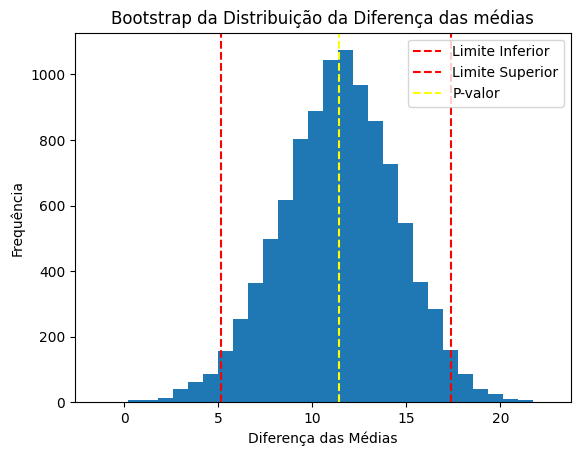

In [12]:
# Calcula valor dos dados
diff_means = br['Brazil'].values.mean() - others['Others'].values.mean()

# Calcula IC da diferença média via boostrap
n_bootstraps = 10000
bootstrap_diffs = []
for _ in range(n_bootstraps):
  br_sample = np.random.choice(br['Brazil'].values, size=len(br['Brazil'].values), replace=True)
  others_sample = np.random.choice(others['Others'].values, size=len(others['Others'].values), replace=True)

  bootstrap_diff = np.mean(br_sample) - np.mean(others_sample)
  bootstrap_diffs.append(bootstrap_diff)

# Calcula intervalo de confiança com 5% de significância
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

plt.hist(bootstrap_diffs, bins=30)
plt.axvline(confidence_interval[0], color='red', linestyle='--', label='Limite Inferior')
plt.axvline(confidence_interval[1], color='red', linestyle='--', label='Limite Superior')
plt.axvline(diff_means, color='yellow', linestyle='--', label='P-valor')
plt.xlabel("Diferença das Médias")
plt.ylabel("Frequência")
plt.title("Bootstrap da Distribuição da Diferença das médias")
plt.legend()
plt.show()

### Conclusão

É possível concluir que o desempenho médio brasileiro é um pouco abaixo da média global. Além disso, é possível ver que o país tem um desempenho bem inconsistente ao longo das competições, o que reflete em um IC que favorece a média brasileira.

## Qual o desempenho médio de cada país?

Agora, vamos investigar o desempenho médio dos países como um todo e tentar predizer manualmente quais seriam os países mais fortes na competição.

Começamos com um scatterplot do desempenho médio:

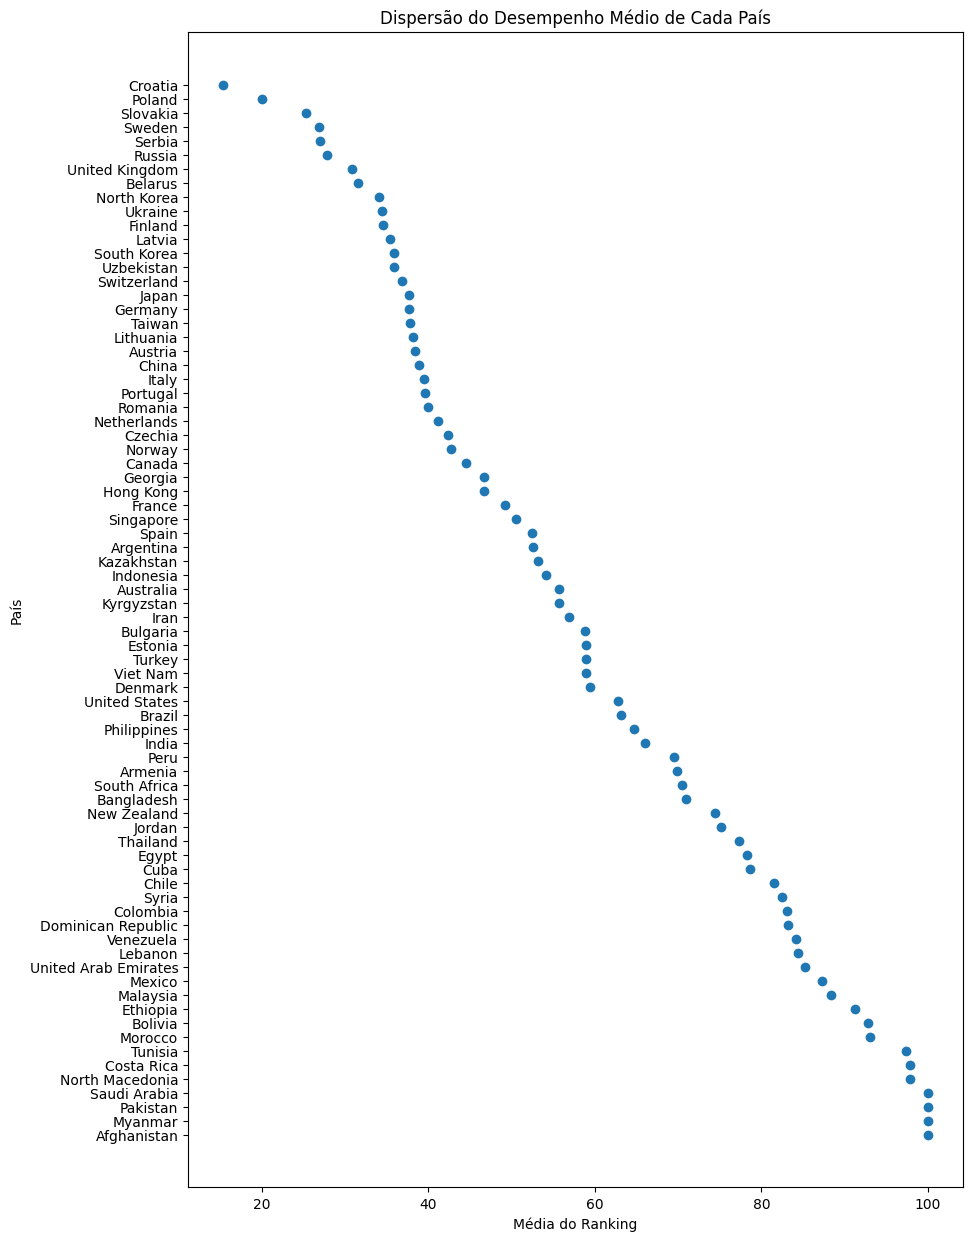

In [13]:
country_means = df.groupby('Country')['Rank'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 15))
plt.scatter(country_means.values, country_means.index)
plt.xlabel("Média do Ranking")
plt.ylabel("País")
plt.title("Dispersão do Desempenho Médio de Cada País")
plt.show()


Comparando o gráfico acima, que mostra o desempenho médio dos países, com o gráfico abaixo, que mostra o desempenho médio do melhor time de cada país, é possível notar uma certa inversão no topo. Países como Estados Unidos e Rússia tem médias relativamente ruins, mas melhores desempenhos muito altos. Isso se deve ao fato desses países terem um número de participantes grande comparado aos outros, o que é ilustrado logo abaixo:

In [14]:
print('Times americanos em 2021:', df[(df['Year'] == 2021) & (df['Country'] == 'United States')]['Team'].nunique())
print('Times russos em 2021:', df[(df['Year'] == 2021) & (df['Country'] == 'Russia')]['Team'].nunique())
print('Número médio de times por país em 2021:', df[df['Year'] == 2021].groupby('Country')['Team'].nunique().mean())

Times americanos em 2021: 14
Times russos em 2021: 11
Número médio de times por país em 2021: 3.119047619047619


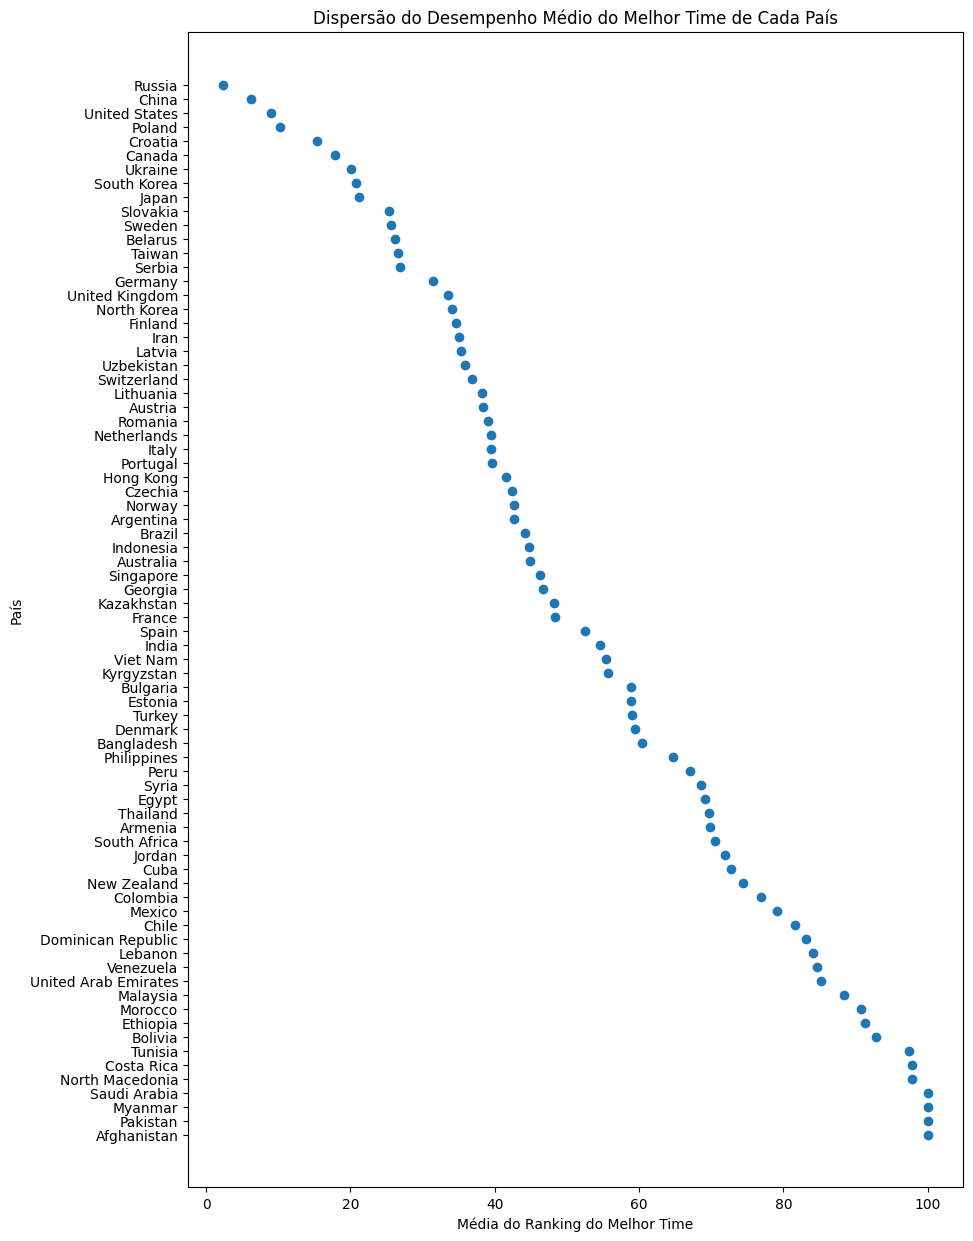

In [15]:
best_teams = df.groupby(['Country', 'Year'])['Rank'].min().reset_index()
country_best_means = best_teams.groupby('Country')['Rank'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15))
plt.scatter(country_best_means.values, country_best_means.index)
plt.xlabel("Média do Ranking do Melhor Time")
plt.ylabel("País")
plt.title("Dispersão do Desempenho Médio do Melhor Time de Cada País")
plt.show()


Para investigar melhor essa diferença do melhor desempenho e o desempenho médio, criamos um gráfico da média da diferença entre o melhor e pior time de cada país:

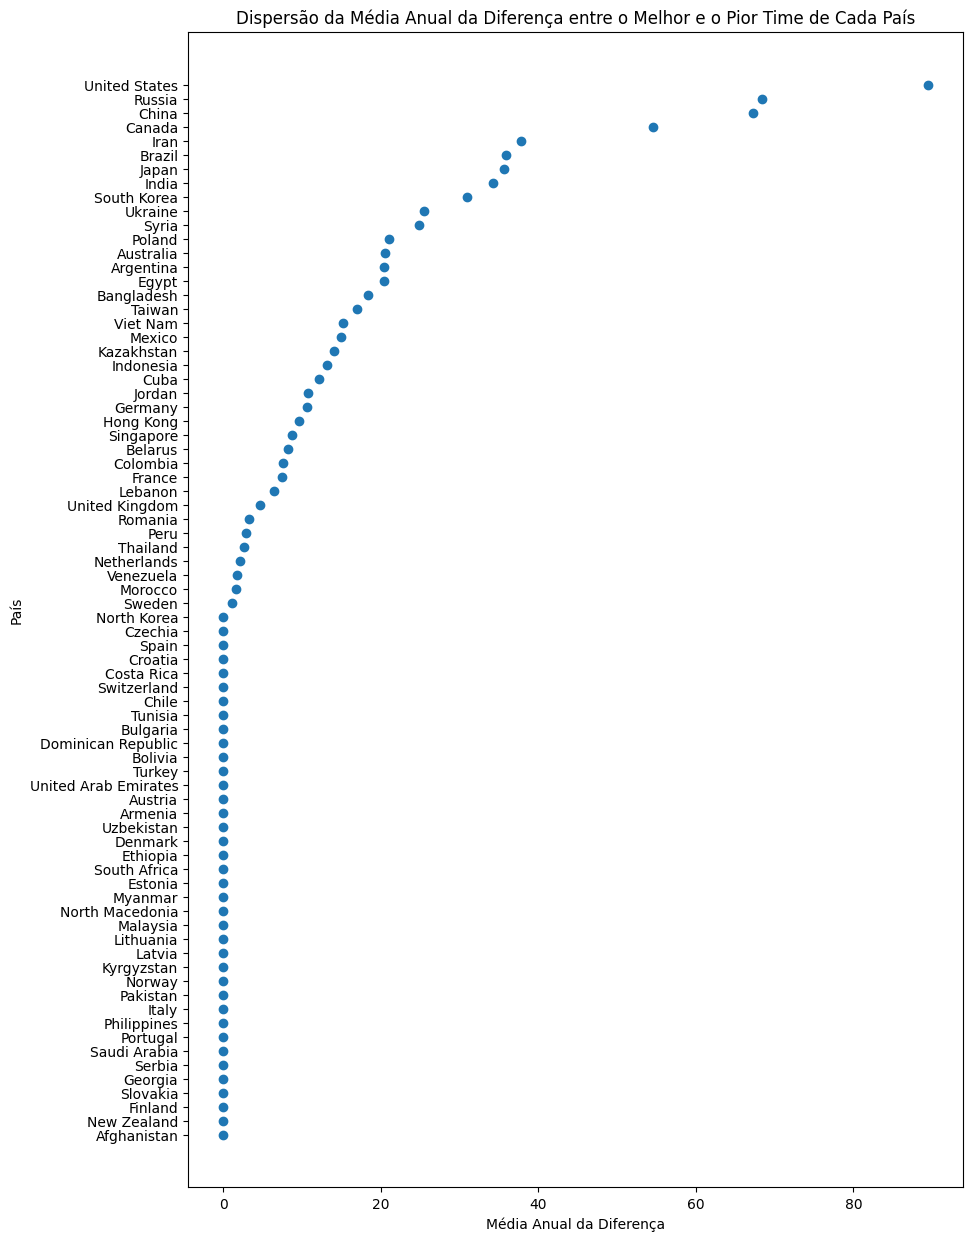

In [16]:
# Calcula a diferença entre o melhor e o pior time de cada país por ano
best_teams = df.groupby(['Country', 'Year'])['Rank'].min().reset_index().copy()
worst_teams = df.groupby(['Country', 'Year'])['Rank'].max().reset_index().copy()
diff_teams = best_teams.merge(worst_teams, on=['Country', 'Year'], suffixes=('_best', '_worst'))
diff_teams['diff'] = diff_teams['Rank_worst'] - diff_teams['Rank_best']

# Calcula a média anual da diferença
mean_diff = diff_teams.groupby('Country')['diff'].mean().sort_values()

# Cria o scatterplot
plt.figure(figsize=(10, 15))
plt.scatter(mean_diff.values, mean_diff.index)
plt.xlabel("Média Anual da Diferença")
plt.ylabel("País")
plt.title("Dispersão da Média Anual da Diferença entre o Melhor e o Pior Time de Cada País")
plt.show()


Para ter uma visualização melhor da distribuição desses valores, fizemos o scatterplot abaixo. É possível notar que essas correlações são enviezadas pelo fato de que a absoluta maioria dos países tem uma participação muito pequena e alguns poucos países tem muitos participantes.

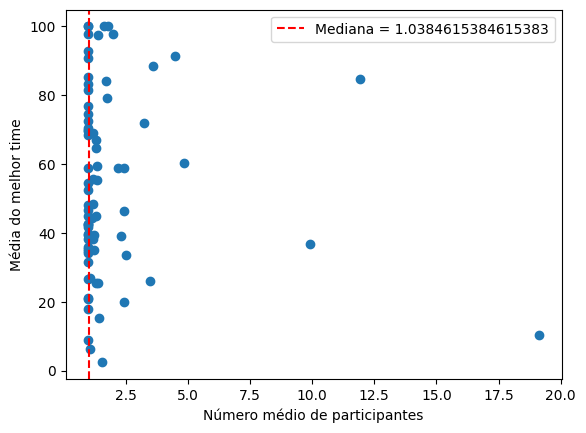

In [17]:
average_num_participants = df.groupby(['Country', 'Year'])['Team'].nunique().groupby('Country').mean()
plt.scatter(average_num_participants.values, country_best_means.values)

# linha vertical na mediana:
plt.axvline(average_num_participants.median(), color='red', linestyle='--', label=f'Mediana = {average_num_participants.median()}')

plt.xlabel("Número médio de participantes")
plt.ylabel("Média do melhor time")
plt.legend()

Por fim, vamos plotar a matriz de correlação de todas essas métricas:

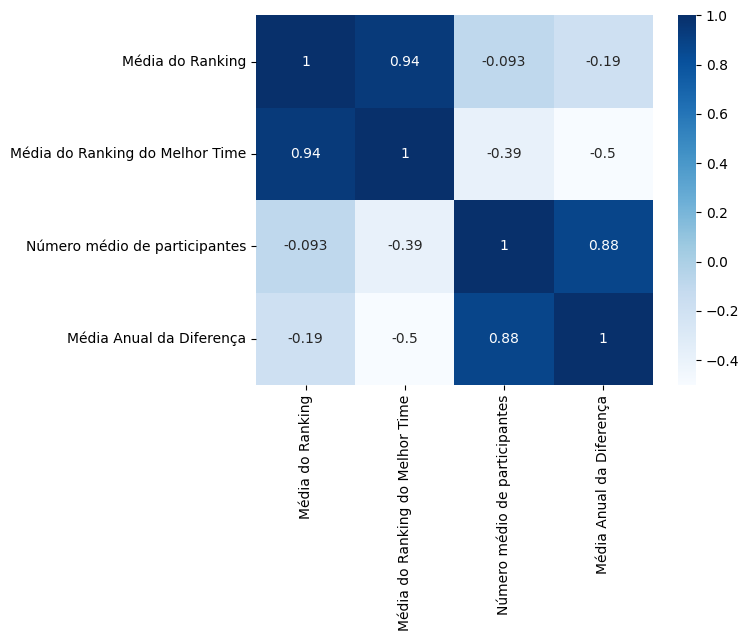

In [18]:
sns.heatmap(pd.concat([country_means, country_best_means, average_num_participants, mean_diff], axis=1).corr(), annot=True, cmap='Blues', xticklabels=['Média do Ranking', 'Média do Ranking do Melhor Time', 'Número médio de participantes', 'Média Anual da Diferença'], yticklabels=['Média do Ranking', 'Média do Ranking do Melhor Time', 'Número médio de participantes', 'Média Anual da Diferença'])
plt.show()

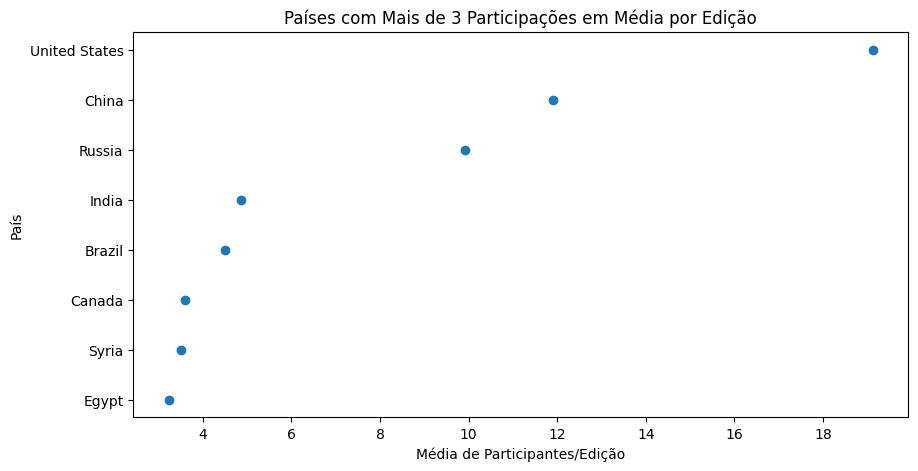

In [19]:
lotsa_teams = average_num_participants[average_num_participants > 3].sort_values()

plt.figure(figsize=(10, 5))
plt.scatter(lotsa_teams.values, lotsa_teams.index)
plt.xlabel("Média de Participantes/Edição")
plt.ylabel("País")
plt.title("Países com Mais de 3 Participações em Média por Edição")
plt.show()


### Conclusão

China, Rússia e Estados Unidos parecem ser os países mais competitivos, considerando tanto o desempenho dos melhores times quanto o número de times classificados.

# Predição e Classificação

Agora, partimos para a utilização de modelos de aprendizado de máquina para tentar predizer métricas e realizar classificações

## Países Competitivos vs Não Competitivos

Vamos comparar a nossa análise manual prévia com o resultado de um modelo de classificação:

Primeiro, tentamos classificar os países que tem desempenho médio global melhor que a mediana:

In [20]:
average_participations = df.groupby('Country')['Team'].count().median().copy()
dfa = df.groupby('Country').filter(lambda x: len(x) >= average_participations).copy()

# Define um limiar para separar países competitivos de não competitivos
threshold = dfa['Rank'].median()

# Cria uma nova coluna 'Competitive' com base no limiar
dfa['Competitive'] = dfa['Rank'] <= threshold

# Prepara os dados
features = dfa[['Country']].copy()
target = dfa['Competitive'].copy()

# Converte as features categóricas para numéricas usando one-hot encoding
features = pd.get_dummies(features, columns=['Country'])

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Treina um modelo RandomForestClassifier
model = RandomForestClassifier(random_state=57)
model.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avalia o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo no conjunto de teste:", accuracy)


Acurácia do modelo no conjunto de teste: 0.7096018735362998


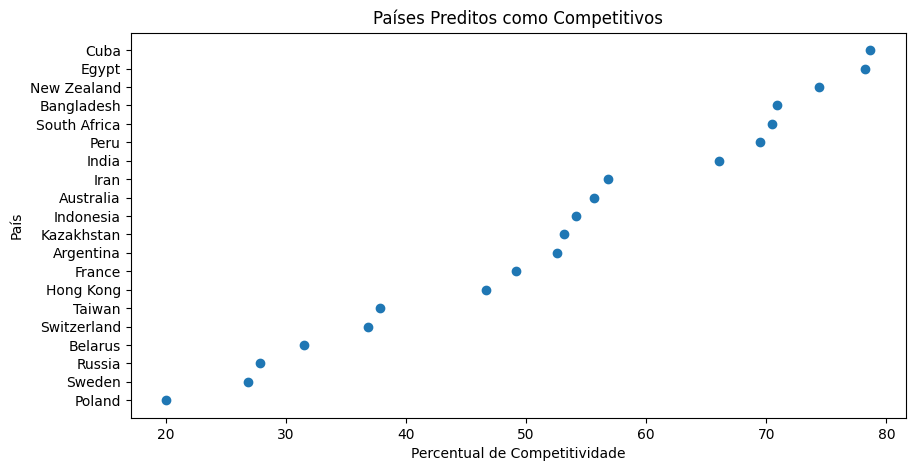

In [21]:
# Obtém os nomes das colunas (países)
country_columns = [col for col in features.columns if col.startswith('Country_')]

# Obtém os índices dos países preditos como competitivos
competitive_indices = model.predict(features) == True

# Mapeia os índices para os nomes dos países
predicted_competitive_countries = [country_columns[i].replace('Country_', '') for i in range(len(country_columns)) if competitive_indices[i]]

competitive = dfa[dfa['Country'].isin(predicted_competitive_countries)].groupby('Country')['Rank'].mean().sort_values()
plt.figure(figsize=(10, 5))
plt.scatter(competitive.values, competitive.index)
plt.xlabel("Percentual de Competitividade")
plt.ylabel("País")
plt.title("Países Preditos como Competitivos")
plt.show()


Segue abaixo a matriz de confusão do modelo:

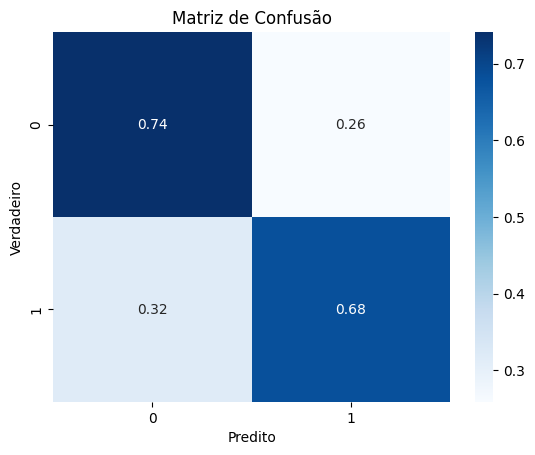

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize= 'true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

Agora, vamos utilizar o desempenho do melhor time, para o critério ser o mesmo da nossa última análise manual:

In [23]:
dfa = df.copy()

# Filtra os desempenhos para conter apenas o melhor time em cada ano
dfa = dfa.groupby(['Country', 'Year'])['Rank'].min().reset_index().copy()

# Define um limiar para separar países competitivos de não competitivos
threshold = dfa['Rank'].median()

# Cria uma nova coluna 'Competitive' com base no limiar
dfa['Competitive'] = dfa['Rank'] <= threshold

# Prepara os dados
features = dfa[['Country']].copy()
target = dfa['Competitive'].copy()

# Converte as features categóricas para numéricas usando one-hot encoding
features = pd.get_dummies(features, columns=['Country'])

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Treina um modelo RandomForestClassifier
model = RandomForestClassifier(random_state=69)
model.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avalia o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo no conjunto de teste:", accuracy)

Acurácia do modelo no conjunto de teste: 0.7125


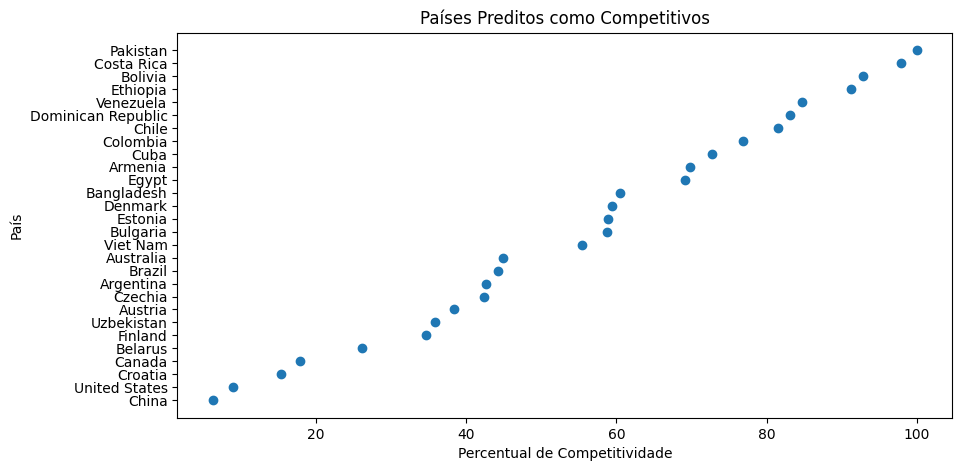

In [24]:
# Obtém os nomes das colunas (países)
country_columns = [col for col in features.columns if col.startswith('Country_')]

# Obtém os índices dos países preditos como competitivos
competitive_indices = model.predict(features) == True

# Mapeia os índices para os nomes dos países
predicted_competitive_countries = [country_columns[i].replace('Country_', '') for i in range(len(country_columns)) if competitive_indices[i]]

competitive = dfa[dfa['Country'].isin(predicted_competitive_countries)].groupby('Country')['Rank'].mean().sort_values()
plt.figure(figsize=(10, 5))
plt.scatter(competitive.values, competitive.index)
plt.xlabel("Percentual de Competitividade")
plt.ylabel("País")
plt.title("Países Preditos como Competitivos")
plt.show()

Segue abaixo a matriz de confusão do modelo:

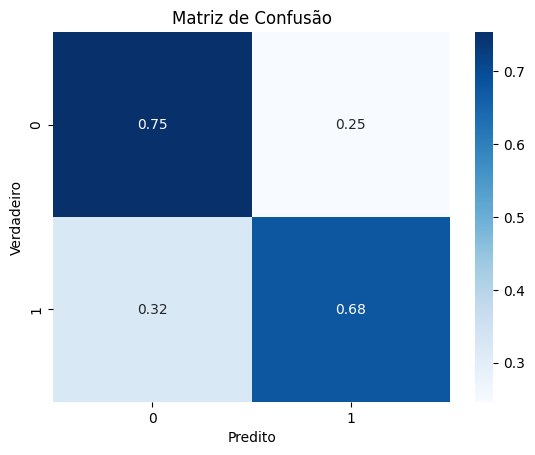

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize= 'true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

Podemos observar que, apesar da acurácia ainda ser relativamente baixa, a lista dos países competivos agora contém tanto a China quanto os Estados Unidos, os dois países com mais times e, portanto, os mais afetados pela mudança da média dos times para o melhor time.

## Predição do Rank de um Time

Agora, vamos tentar predizer o Rank de um time. As variáveis que podem ser explicativas são:



*   País
*   Sede da edição
*   "Score Percentage": Essa feature indica a porcentagem de questões da prova que o time resolveu, o que significa que essa métrica já é normalizada.
*   "Penalty": Os times recebem uma certa quantidade de penalidade baseada no tempo que demoraram para resolver cada questão + um adicional a cada submissão que falha.



Vamos então, calcular a matriz de correlação das features númericas:

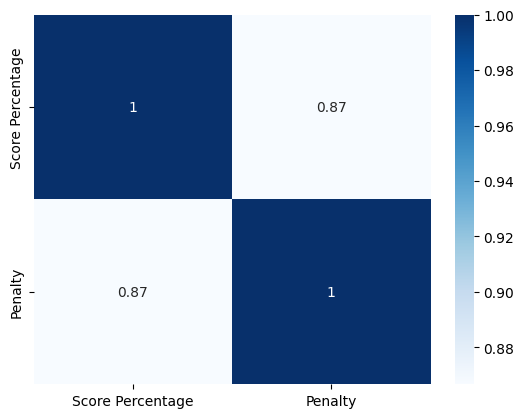

In [26]:
features_selected = ['Score Percentage', 'Penalty']

sns.heatmap(df[features_selected].corr(), annot=True, cmap='Blues')
plt.show()

A correlação existe, o que é de se esperar porque um time sofre penalidades de acordo com o tempo que demoram para resolver um problema corretamente, ou a quantidade de tentativas erradas caso não consigam. Assim, um time com mais problemas recebe maior penalidade na média.

Por isso, vamos investigar também se um modelo com apenas uma delas consegue ser melhor que um que use as duas.

Começamos com um modelo que usa todas as features:

In [27]:
models = []

In [28]:
features_selected = ['Country', 'Host', 'Score Percentage', 'Penalty']
dfa = df.dropna(subset=features_selected)
features = dfa[features_selected].copy()
target = dfa['Rank'].copy()

features = pd.get_dummies(features, columns=['Country', 'Host'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
models.append(model)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
lr_mse_all_feats = mse
print("[Regressão Linear] Erro médio quadrático no conjunto de teste:", mse)

model = RandomForestRegressor(random_state=32)
model.fit(X_train, y_train)
models.append(model)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rf_mse_all_feats = mse
print("[Random Forest Regressor] Erro médio quadrático no conjunto de teste:", mse)

[Regressão Linear] Erro médio quadrático no conjunto de teste: 111.18795563392781
[Random Forest Regressor] Erro médio quadrático no conjunto de teste: 31.017241176124266


Agora, vamos ver se um modelo com apenas as variáveis númericas consegue um desempenho melhor, o que seria surpreendente:

In [29]:
features_selected = ['Score Percentage', 'Penalty']
dfa = df.dropna(subset=features_selected)
features = dfa[features_selected].copy()
target = dfa['Rank'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
models.append(model)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
lr_mse_num_feats = mse
print("[Regressão Linear] Erro médio quadrático no conjunto de teste:", mse)

model = RandomForestRegressor(random_state=12)
model.fit(X_train, y_train)
models.append(model)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rf_mse_num_feats = mse
print("[Random Forest Regressor] Erro médio quadrático no conjunto de teste:", mse)

[Regressão Linear] Erro médio quadrático no conjunto de teste: 145.06549397583376
[Random Forest Regressor] Erro médio quadrático no conjunto de teste: 120.56609604387722


Como imaginavamos, as features categóricas ajudam. Finalmente, vamos testar usar apenas uma das features numéricas:

In [30]:
features_selected = ['Country', 'Host', 'Score Percentage']
dfa = df.dropna(subset=features_selected)
features = dfa[features_selected].copy()
target = dfa['Rank'].copy()

features = pd.get_dummies(features, columns=['Country', 'Host'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
models.append(model)


y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
lr_mse_score_percentage = mse
print("[Regressão Linear] Erro médio quadrático no conjunto de teste:", mse)

model = RandomForestRegressor(random_state=32)
model.fit(X_train, y_train)
models.append(model)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rf_mse_score_percentage = mse
print("[Random Forest Regressor] Erro médio quadrático no conjunto de teste:", mse)

[Regressão Linear] Erro médio quadrático no conjunto de teste: 116.60357499748082
[Random Forest Regressor] Erro médio quadrático no conjunto de teste: 67.62829665494087


Segue abaixo um resumo do erro quadrático médio no conjunto de teste para todos os modelos:

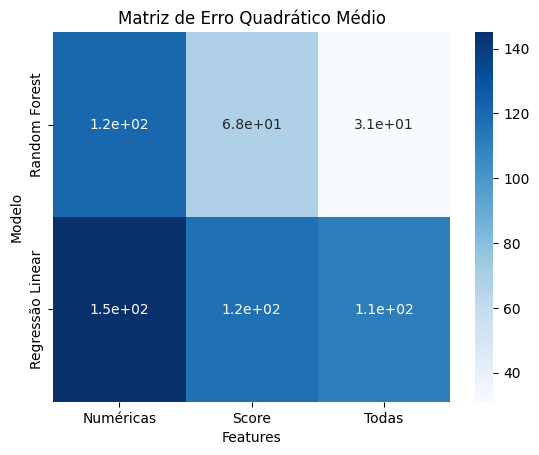

In [31]:
data = [
    ["Regressão Linear", "Todas", lr_mse_all_feats],
    ["Random Forest", "Todas", rf_mse_all_feats],
    ["Regressão Linear", "Numéricas", lr_mse_num_feats],
    ["Random Forest", "Numéricas", rf_mse_num_feats],
    ["Regressão Linear", "Score", lr_mse_score_percentage],
    ["Random Forest", "Score", rf_mse_score_percentage]
]
data = pd.DataFrame(data, columns=["Modelo", "Features", "MSE"])
sns.heatmap(data.pivot(index="Modelo", columns="Features", values="MSE"),
            fmt = '.1e',
            annot=True,
            cmap='Blues')
plt.title('Matriz de Erro Quadrático Médio')
plt.show()


Aparentemente, o melhor modelo se trata do RandomForestClassifier utilizando de todas as features pré-selecionadas. Vamos ver qual a posição que ele prediz pra um dado fictício, de um time brasileiro fazendo uma prova nos Estados Unidos e completanto apenas metade da prova:

In [32]:
model = models[1]
import pandas as pd
# Cria um dicionário com os dados do time brasileiro
team_data = {
    'Country': 'Brazil',
    'Host': 'United States',
    'Score Percentage': 0.50,  # Exemplo de porcentagem de pontuação
    'Penalty': 1000  # Exemplo de penalidade
}

# Cria um DataFrame a partir do dicionário
team_df = pd.DataFrame([team_data])

# Código copiado das células acima para recuperarmos as colunas vistas durante o treino desse modelo:

features_selected = ['Country', 'Host', 'Score Percentage', 'Penalty']
dfa = df.dropna(subset=features_selected)
features = dfa[features_selected].copy()
target = dfa['Rank'].copy()
features = pd.get_dummies(features, columns=['Country', 'Host'])

# Converte as features categóricas para numéricas usando one-hot encoding
team_df_encoded = pd.get_dummies(team_df, columns=['Country', 'Host'])

# Ajusta as colunas do DataFrame para corresponder às colunas do modelo treinado
team_df_encoded = team_df_encoded.reindex(columns=features.columns, fill_value=0)

# Exibe o DataFrame com os dados do time brasileiro
print(model.predict(team_df_encoded)[0])

34.7241964985471


 É possível ver que a final mundial se trata de uma prova difícil, visto que um time que fez apenas metade da prova é predito como ficando por volta do 30° lugar (em 100).

### Conclusão

 É possível predizer de forma razoável o posicionamento final de um time baseado em suas métricas de performance e informações como o país do time e o país sede. Porém, fica evidente que o resultado é longe de perfeito --- o que é evidenciado pelo erro quadrado no conjunto de teste. Logo, outros fatores também são significativos no resultado final dos times.